# English

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
background = np.ones((80,200,3) , dtype = 'uint8') * 200
background = Image.fromarray(background)

In [ ]:
draw = ImageDraw.Draw(background)

In [ ]:
background

In [ ]:
draw

In [ ]:
font = ImageFont.truetype('Redressed-Regular.ttf', size=45)

In [ ]:
font

In [ ]:
message = "سلام"
color = (0,0,128)

In [ ]:
(x, y) = (30, 20)
draw.text((x, y), message, fill=color, font=font, direction='rtl')

In [ ]:
background

# Persian

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import arabic_reshaper
from PIL import Image, ImageDraw, ImageFont
from bidi.algorithm import get_display

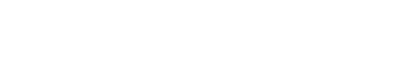

In [70]:
background = np.ones((80,400,3) , dtype = 'uint8') * (255,255,255)
background = background.astype('uint8')
background = Image.fromarray(background)
draw = ImageDraw.Draw(background)
font = ImageFont.truetype('fonts/IranNastaliq.ttf', size=60)
raw_test = 'سلام'
background

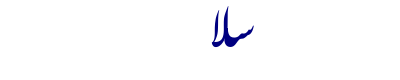

In [71]:
reshaped_text = arabic_reshaper.reshape(raw_test)
bidi_text = get_display(reshaped_text)
color = (0,0,128)
(x, y) = (200, 40)
draw.text((x, y), bidi_text, fill=color, font=font, anchor='mm')
background

# Dataset Creation

In [789]:
import numpy as np
import PIL
import arabic_reshaper
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
from bidi.algorithm import get_display
import os
from glob import glob
import cv2
from tqdm import tqdm
import sys
from time import time as t
from PIL import ImageEnhance
if 'ipykernel' in sys.modules:
    from tqdm.notebook import tqdm
    %matplotlib inline
else:
    from qtdm import tqdm

In [725]:
def create_word(word, font_name, offsets = (0,0) , bg = None , size = 60, color = None , bg_size = (100,300), bg_color = (200)):
    if bg is None:
        bg_size = np.array(bg_size).astype(int)
        background = np.ones((*bg_size,3) , dtype = 'uint8') * bg_color
        background = background.astype('uint8')
        background = Image.fromarray(background)
    else : background = bg
    
    if color is None:
        color = tuple(np.random.randint(low = 0, high = 70, size = 3))
    
    draw = ImageDraw.Draw(background)
    font = ImageFont.truetype(font_name, size=size)
    reshaped_text = arabic_reshaper.reshape(word)
    bidi_text = get_display(reshaped_text)
    o_x_offset, o_y_offset = offsets
#     print(background.size)
#     print(o_x_offset,o_y_offset)
    o_x_offset = -int(o_x_offset * background.size[0])
    o_y_offset = -int(o_y_offset * background.size[1])
#     print(o_x_offset,o_y_offset)
    x, y = background.size[0]//2 + o_x_offset ,background.size[1]//2 + o_y_offset
    x = x + int(np.random.randint(low = -background.size[0]//30, high = background.size[0]//30, size = 1))
    y = y + int(np.random.randint(low = -background.size[1]//30, high = background.size[1]//30, size = 1))
    draw.text((x, y), bidi_text, fill=color, font=font, anchor = 'mm')
    return background

In [726]:
def get_all_fonts(fonts_dir):
    fonts_names = glob(os.path.join(fonts_dir , '*ttf'))
#     print(f'Found {len(fonts_names)} fonts in the given directory')
    return fonts_names

In [727]:
def get_all_bgs(bgs_dir):
    bgs_names = glob(os.path.join(bgs_dir , '*'))
#     print(f'Found {len(bgs_names)} backgrounds in the given directory')
    all_imgs = []
    for bg_name in bgs_names:
        bg = cv2.imread(bg_name)[...,::-1]
        all_imgs.append(bg)
    return all_imgs

In [728]:
def get_all_words(corpuses_dir):
    all_words = []
    corpus_names = glob(os.path.join(corpuses_dir , '*txt'))
    print(f'There are {len(corpus_names)} text files in the corpus')
    for txt_file in corpus_names:
        file = open(txt_file)
        lines = file.read()
        all_words.extend(lines.split('\n'))
#     print(f'Found {len(all_words)} words in the dataset.')
    all_words = list(filter(lambda x:len(x), all_words))
    return all_words

In [734]:
def img_to_bbx(img):
    img = np.array(img)
    args = np.argwhere(img[...,0]>0)
    y_max, x_max = np.max(args,0)
    y_min, x_min = np.min(args,0)
#     plt.imshow(img[y_min:y_max, x_min:x_max,:])
#     plt.imshow(img)
    bbx = (x_min,x_max), (y_min, y_max)
#     print(y_min,y_max)
    o_x_offset = ((x_min + x_max) / img.shape[1] ) - 1
    o_y_offset = ((y_min + y_max) / img.shape[0] ) - 1
    offsets = [o_x_offset , o_y_offset]
#     print(o_x_offset,o_y_offset)
    sizes = np.array((y_max- y_min, x_max - x_min))
    return offsets, sizes

In [730]:
def get_rect_size_for_word(word, font, size, bg_size = (400,700)):
    img = create_word(word, font_name = font, size = size, color = (255,255,255), 
                bg_size = bg_size, bg_color = (0,0,0))
    return img_to_bbx(img)

([0.0585714285714285, -0.02749999999999997], array([51, 91]))

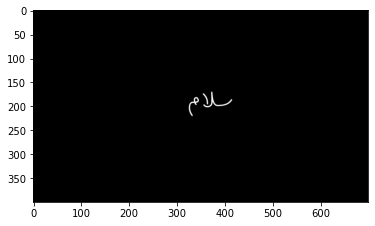

In [731]:
get_rect_size_for_word(all_words[i], all_fonts[b], size = size)

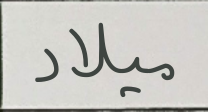

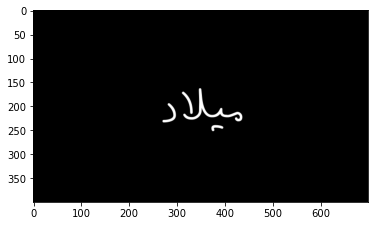

In [732]:
i = 3
b = 0
size = 200

offsets, sizes = get_rect_size_for_word(all_words[i], all_fonts[b], size = size)
bg = all_bgs[3].copy()
bg = resize_bg(bg, (1.25 *sizes))
# print(sizes)
create_word(all_words[i],offsets = offsets , font_name= all_fonts[b] ,bg = bg,size= int(size//1.2))

In [675]:
plt.imshow(np.array(new))

In [669]:
0.06499999999999995 * 117

7.604999999999993

In [619]:
(414 + 254 - 1) 

667

In [620]:
data, img = get_rect_size_for_word(all_words[0], all_fonts[2], size = 100)

0 0


In [621]:
img = create_word(all_words[0] , font_name = all_fonts[0] , size = size, color = (255,255,255), 
                bg_size = (100,200), bg_color = (0,0,0))
img_arr = np.array(img)

0 0


In [622]:
%matplotlib qt
plt.imshow(img_arr)

In [623]:
args = np.argwhere(img_arr[...,0]>0)

In [624]:
args.max(0)

array([ 84, 145])

In [150]:
def resize_bg(backgroud_img, target_size):
    bg  = backgroud_img.copy()
    y,x = target_size.astype(int)
    bg  = cv2.resize(bg, (x,y))
    bg = Image.fromarray(bg)
    return bg

In [835]:
def augment(img, p = 0.5):
    filters = [ImageFilter.GaussianBlur(), ImageFilter.SHARPEN()]
    epsilon = np.random.rand(1)
    if epsilon < p:
        epsilon = int(epsilon * len(filters))
        f = filters[epsilon]
        if f.name == 'GaussianBlur':
            f.radius = np.random.rand(1) * 1.5
        img = img.filter(f)
        
        epsilon = np.random.rand(1)
        if epsilon < 0.4:
            img = img.rotate(np.random.randint(-4,4,1))

        epsilon = np.random.rand(1)
        if epsilon < 0.4:
            img = ImageEnhance.Contrast(img).enhance(np.random.rand(1) + 0.5)
    
    return img

In [421]:
def create_data_set(words, fonts, bgs ,size = None, noise_p = 0.5 ,output_dir = 'outputs/'):
    t1 = t()
    counter = 0
    os.makedirs(output_dir , exist_ok = True)
    print('Output directory craeted.')
    assert isinstance(words, str) or isinstance(all_words, list) , "words argument should be either list or str"
    if isinstance(words, str):
        words = get_all_words(words)
    assert isinstance(fonts, str) or isinstance(fonts, list)  , "fonts argument should be either list or str"
    if isinstance(fonts, str):
        fonts = get_all_fonts(fonts)
    assert isinstance(bgs, str) or isinstance(bgs, list)  , "bgs argument should be either list or str"
    if isinstance(bgs, str):
        bgs = get_all_bgs(bgs)
    print(f'Found {len(words)} words.')
    print(f'Found {len(fonts)} fonts.')
    print(f'Found {len(bgs)} background images.')
    print(f'In total {len(words) * len(fonts) * len(bgs)} Images will be created')
    for w_idx, word in enumerate(tqdm(words)):
        for f_idx, font in enumerate(fonts):
            for bg_idx, bg in enumerate(bgs):
                if isinstance(size, int):
                    pass
                elif isinstance(size, list):
                    size = np.random.choice(size)
                elif size == 'random' or size is None:
                    size = int(np.random.randint(110,150,1))
                    
                bbx, sizes = get_rect_size_for_word(word, font, size)
                bg = resize_bg(bg, 1.25 * sizes)
                img = create_word(word, font_name= font,bg = bg, bg_size = 1.25*sizes, size= int(size//1.2))
                img = augment(img, p = noise_p)
                img.save(os.path.join(output_dir , f'w_{w_idx:04d}f_{f_idx:04d}b_{bg_idx:04d}.png' ))
                counter += 1
    print(f'{counter} Images created')
    t2 = t()
    print(f'Time Taken : {np.round(t2-t1,2)} second')

In [422]:
create_data_set('word_bank/','fonts/', 'backgrounds/', size = None)

Output directory craeted.
There are 2 text files in the corpus
Found 14 words.
Found 5 fonts.
Found 6 background images.
In total 420 Images will be created



420 Images created
Time Taken : 29.72 second


In [112]:
all_words = get_all_words('word_bank/')
all_fonts = get_all_fonts('fonts/')
all_bgs   = get_all_bgs('backgrounds/')

There are 2 text files in the corpus


In [113]:
output_dir = 'outputs/'
os.makedirs(output_dir , exist_ok = True)

In [114]:
all_fonts

['fonts/A Badkhat.ttf',
 'fonts/a-JannatLT-Regular.ttf',
 'fonts/B Ziba_0.ttf',
 'fonts/Persian Khat Khati 02.ttf',
 'fonts/Persian Toomar.ttf']

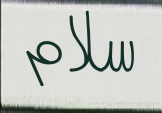

In [786]:
i = 0

bbx, sizes = get_rect_size_for_word(all_words[i], all_fonts[2], size = 100)
size = 100
bg = all_bgs[0].copy()
bg = resize_bg(bg, (1.25 *sizes))
# print(sizes)
img = create_word(all_words[i], font_name= all_fonts[2] ,bg = bg, bg_size = 1.2*sizes, size= int(size//1.2))
img

In [752]:
from PIL import ImageEnhance

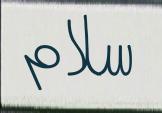

In [753]:
img

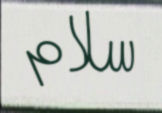

In [852]:
augment(img)

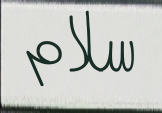

In [868]:
ImageEnhance.Color(img).enhance(np.random.rand(1) + 0.5)

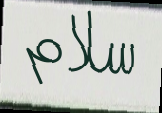

In [787]:
img.rotate(-3)

In [ ]:
from scipy.ndimage import rotate
from scipy.misc import face
from matplotlib import pyplot as plt

# Backgrounds

In [ ]:
import seaborn as sns
sns.heatmap(img_arr[...,0])

In [ ]:
plt.imshow(img_arr)

In [ ]:
from skimage import io
from skimage import transform as tf
afine_tf = tf.AffineTransform(shear=0.7)
modified = tf.warp(img_arr, inverse_map = afine_tf)*255
modified = modified.astype('uint8')
plt.imshow(modified)

In [ ]:
modified.shape

In [ ]:
bg = np.ones((100,150,3)) * (250,250,250)
bg = bg.astype('uint8')
# plt.imshow(bg)

In [ ]:
np.unique(bg)

In [ ]:
modified = modified.astype('uint8')
modified[modified == [0,0,0]] = bg[img_arr == [0,0,0]] 
modified = modified.astype('uint8')

In [ ]:
bg[modified != [0,0,0]] = modified[modified != [0,0,0]] 
bg = bg.astype('uint8')

In [ ]:
plt.imshow(modified)

In [ ]:
plt.imshow(bg + modified)